# **Number Plate Detection of Vehicles**

---



# Colab Integration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

%cd /content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles

/content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles


In [3]:
!ls

 App.ipynb  'Dataset Split'   Model		 runs
 Data.csv    data.yaml	     'New streamlit'	 Streamlit
 DataSet     eda_variants     requirements.txt	 training_dataset


In [20]:
!pip install -r requirements.txt

In [21]:
# Paste & run: robust blur + sample visualization
import random, cv2,shutil,glob, os,sys, numpy as np,pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from pillow_heif import register_heif_opener
from pyngrok import ngrok
import csv
import threading
import time
from ultralytics import YOLO
import torch
import pytesseract
import easyocr
from tqdm import tqdm
import streamlit as st

register_heif_opener()

# Data Collection
data collection is a flexible step that can come in at multiple points in your workflow whenever you need to gather or refine your data further.

# Exploratory Data Analysis (EDA)

## **Dataset Composition**

In [ ]:


DATASET = "DataSet"
IMAGES_DIR = Path(DATASET) / "images"
LABELS_DIR = Path(DATASET) / "yolo_labels"

# -----------------------------------------
# Function to detect file extensions
# -----------------------------------------
def detect_file_types(folder: Path):
    exts = {}
    files = list(folder.iterdir())
    for f in files:
        if f.is_file():
            ext = f.suffix.lower()
            exts[ext] = exts.get(ext, 0) + 1
    return exts, files

# -----------------------------------------
# Detect image directory file types
# -----------------------------------------
image_exts, image_files = detect_file_types(IMAGES_DIR)
label_exts, label_files = detect_file_types(LABELS_DIR)

# Convert to stems
image_stems = {f.stem for f in image_files if f.suffix.lower() != ""}
label_stems = {f.stem for f in label_files if f.suffix.lower() == ".txt"}

# -----------------------------------------
# Matching logic
# -----------------------------------------
matched = image_stems & label_stems
unmatched_images = image_stems - label_stems
unmatched_labels = label_stems - image_stems

# -----------------------------------------
# PRINT RESULTS
# -----------------------------------------

print("========== FILE TYPE REPORT ==========")

print("\nIMAGES DIRECTORY FILE TYPES:")
for ext, count in image_exts.items():
    print(f"{ext}: {count} files")

print("\nLABELS DIRECTORY FILE TYPES:")
for ext, count in label_exts.items():
    print(f"{ext}: {count} files")



print("\n========== FILE COUNTS ==========")
print(f"Total files in images directory : {len(image_files)}")
print(f"Total files in labels directory : {len(label_files)}")

print("\n========== MATCHING REPORT ==========")
print(f"Matched (image + label exist)         : {len(matched)}")
print(f"Unmatched images (label missing)      : {len(unmatched_images)}")
print(f"Unmatched labels (image missing)      : {len(unmatched_labels)}")

print("\nSample unmatched images (first 10):")
for x in list(unmatched_images)[:10]:
    print(" -", x)

print("\nSample unmatched labels (first 10):")
for x in list(unmatched_labels)[:10]:
    print(" -", x)


classes_file = LABELS_DIR / "classes.txt"

# Check file exists
if not classes_file.exists():
    print("classes.txt not found!")
else:
    print("===== CLASS NAMES =====")
    with classes_file.open("r") as f:
        classes = [line.strip() for line in f.readlines() if line.strip()]

    for idx, cls in enumerate(classes):
        print(f"Class {idx}: {cls}")

    print("\nTotal Classes:", len(classes))

print("\nAnalysis Complete!")


========== FILE TYPE REPORT ==========

IMAGES DIRECTORY FILE TYPES:
.jpg: 410 files
.mp4: 2 files
.heic: 4 files

LABELS DIRECTORY FILE TYPES:
.txt: 116 files

========== FILE COUNTS ==========
Total files in images directory : 416
Total files in labels directory : 116

========== MATCHING REPORT ==========
Matched (image + label exist)         : 115
Unmatched images (label missing)      : 301
Unmatched labels (image missing)      : 1

Sample unmatched images (first 10):
 - 20230626_091555
 - 20230626_091641
 - 20230810_172202
 - 20230702_133115
 - 20230515_131318
 - 20230714_172236
 - 20230719_105038
 - 20230518_092143
 - 20230516_154216
 - 20230518_091837

Sample unmatched labels (first 10):
 - classes
===== CLASS NAMES =====
Class 0: plate

Total Classes: 1

Analysis Complete!


In [ ]:
from PIL import Image
import imagehash

# Paths (IMAGES_DIR must be a Path object)
img1 = Image.open(IMAGES_DIR / "20230518_091953.jpg")
img2 = Image.open(IMAGES_DIR / "20230518_091953(0).jpg")

hash1 = imagehash.average_hash(img1)
hash2 = imagehash.average_hash(img2)

print("Hash 1:", hash1)
print("Hash 2:", hash2)
print("Difference:", hash1 - hash2)

if hash1 - hash2 == 0:
    print("Both images are identical!")
else:
    print("Images are different.")


Hash 1: 787cfcfc9cf83060
Hash 2: e0607478f8f0f060
Difference: 16
Images are different.


## **Bounding Box Distribution**

In [ ]:
# Bounding Box Distribution + Visual Sampling (A + B)
# Run in Colab or local environment (make sure OpenCV, PIL, matplotlib, numpy installed).

from pathlib import Path
import random
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
import csv
import sys

# ---------- CONFIG ----------
DATASET = "DataSet"
IMAGES_DIR = Path(DATASET) / "images"
LABELS_DIR = Path(DATASET) / "yolo_labels"

SAMPLE_N_IMAGES = 10   # random images to show with boxes
RANDOM_SEED = 42
# ----------------------------

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# helper: safe image open (PIL preferred, fallback to cv2)
def open_image_try_all(path: Path):
    try:
        # PIL open (works for most formats)
        img = Image.open(path)
        img = ImageOps.exif_transpose(img)  # fix rotation metadata
        img_rgb = img.convert("RGB")
        return img_rgb
    except Exception as e:
        # fallback to cv2 (BGR -> RGB)
        try:
            arr = cv2.imread(str(path))
            if arr is None:
                raise RuntimeError("cv2.imread returned None")
            arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
            return Image.fromarray(arr)
        except Exception as e2:
            # cannot open
            return None

# collect label files
label_files = list(LABELS_DIR.glob("*.txt"))
label_index = {p.stem: p for p in label_files}

# collect image files (all files) and try to pair with labels
all_image_files = [p for p in IMAGES_DIR.iterdir() if p.is_file()]
image_index = {p.stem: p for p in all_image_files}

# matched image stems
matched_stems = sorted(set(image_index.keys()) & set(label_index.keys()))

# data accumulators
per_image_box_counts = {}
bbox_widths_norm = []   # normalized widths (0..1)
bbox_heights_norm = []  # normalized heights (0..1)
bbox_areas_norm = []
invalid_label_lines = []   # (label_path, line, reason)
bbox_count_total = 0
class_counts = {}

# iterate matched labels and parse
for stem in matched_stems:
    lbl_path = label_index[stem]
    img_path = image_index.get(stem)
    # open image to get size
    img = open_image_try_all(img_path)
    if img is None:
        # skip if image cannot be read (report)
        invalid_label_lines.append((lbl_path.name, None, "image_unreadable"))
        continue
    W, H = img.size
    box_count = 0
    try:
        lines = lbl_path.read_text().strip().splitlines()
    except Exception as e:
        invalid_label_lines.append((lbl_path.name, None, f"label_read_error:{e}"))
        continue
    if len(lines) == 0:
        # zero boxes
        per_image_box_counts[stem] = 0
        continue
    for li, line in enumerate(lines, start=1):
        parts = line.strip().split()
        if len(parts) != 5:
            invalid_label_lines.append((lbl_path.name, line, f"bad_cols({len(parts)})"))
            continue
        cls_s, x_s, y_s, w_s, h_s = parts
        # numeric check
        try:
            cls_id = int(float(cls_s))
            x = float(x_s); y = float(y_s); w = float(w_s); h = float(h_s)
        except Exception as e:
            invalid_label_lines.append((lbl_path.name, line, f"non_numeric:{e}"))
            continue
        # check normalization bounds
        if not (0.0 <= x <= 1.0 and 0.0 <= y <= 1.0 and 0.0 <= w <= 1.0 and 0.0 <= h <= 1.0):
            invalid_label_lines.append((lbl_path.name, line, "out_of_bounds"))
            # still include but mark
        # compute pixel sizes
        width_px = w * W
        height_px = h * H
        area_norm = (w * h)
        bbox_widths_norm.append(w)
        bbox_heights_norm.append(h)
        bbox_areas_norm.append(area_norm)
        class_counts[cls_id] = class_counts.get(cls_id, 0) + 1
        box_count += 1
        bbox_count_total += 1
    per_image_box_counts[stem] = box_count

# Basic text outputs (A)
print("===== BOUNDING BOX DISTRIBUTION REPORT =====")
print(f"Total matched images analyzed: {len(per_image_box_counts)}")
print(f"Total bounding boxes parsed: {bbox_count_total}")
print(f"Images with 0 boxes (Empty labels): {sum(1 for v in per_image_box_counts.values() if v==0)}")
print(f"Images with >=1 boxes: {sum(1 for v in per_image_box_counts.values() if v>0)}")
print()

# class counts
print("Class counts (from labels):")
for cls, cnt in sorted(class_counts.items()):
    print(f" Class {cls}: {cnt}")
print()

# invalid lines summary
print("Invalid / suspicious label lines (sample up to 20):")
for item in invalid_label_lines[:20]:
    print(" ", item)
print(f"... total invalid entries: {len(invalid_label_lines)}")
print()

# per-image box count stats
counts = list(per_image_box_counts.values())
if counts:
    print("Per-image bounding box counts (on matched images):")
    print(" min:", min(counts), " max:", max(counts), " mean:", statistics.mean(counts), " median:", statistics.median(counts))
else:
    print("No per-image counts available.")
print()

# bbox size stats (normalized)
if bbox_widths_norm and bbox_heights_norm:
    def stats(arr):
        return {
            "min": min(arr),
            "max": max(arr),
            "mean": float(np.mean(arr)),
            "median": float(np.median(arr)),
            "std": float(np.std(arr)),
            "p10": float(np.percentile(arr,10)),
            "p90": float(np.percentile(arr,90))
        }
    w_stats = stats(bbox_widths_norm)
    h_stats = stats(bbox_heights_norm)
    a_stats = stats(bbox_areas_norm)
    print("Bounding box width stats:", w_stats)
    print("Bounding box height stats:", h_stats)
    print("Bounding box area stats:", a_stats)
else:
    print("No bounding box width/height data found.")
print()

# ---------- PLOTS (matplotlib) ----------
# Ensure interactive backend works; in Colab these will be inline
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(bbox_widths_norm, bins=40)
plt.title("BBox width (norm)")
plt.subplot(1,3,2)
plt.hist(bbox_heights_norm, bins=40)
plt.title("BBox height (norm)")
plt.subplot(1,3,3)
plt.hist(bbox_areas_norm, bins=40)
plt.title("BBox area (norm)")
plt.tight_layout()
plt.show()

# scatter width vs height
plt.figure(figsize=(6,5))
plt.scatter(bbox_widths_norm, bbox_heights_norm, alpha=0.5, s=8)
plt.xlabel("width (norm)")
plt.ylabel("height (norm)")
plt.title("BBox width vs height ")
plt.grid(True)
plt.show()

# class distribution bar chart
plt.figure(figsize=(5,3))
cls_items = sorted(class_counts.items())
if cls_items:
    labels = [str(c) for c,_ in cls_items]
    vals = [v for _,v in cls_items]
    plt.bar(labels, vals)
    plt.title("Class counts")
    plt.xlabel("class id")
    plt.ylabel("count")
    plt.show()
else:
    print("No class count data to plot.")

# ---------- B: Random sample of images with boxes (up to SAMPLE_N_IMAGES) ----------
print(f"\nShowing up to {SAMPLE_N_IMAGES} random matched images with their bounding boxes overlaid...")

available_for_plot = [stem for stem, cnt in per_image_box_counts.items() if cnt>0]
sample = random.sample(available_for_plot, min(SAMPLE_N_IMAGES, len(available_for_plot)))

def draw_boxes_on_image_pil(img_pil, label_lines):
    draw = img_pil.copy()
    arr = np.array(draw)
    h, w = arr.shape[0], arr.shape[1]
    for line in label_lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        try:
            cls_id = int(float(parts[0]))
            xc = float(parts[1]); yc = float(parts[2]); bw = float(parts[3]); bh = float(parts[4])
        except:
            continue
        # convert normalized to pixel coordinates
        box_w = bw * w
        box_h = bh * h
        cx = xc * w
        cy = yc * h
        x1 = int(cx - box_w/2)
        y1 = int(cy - box_h/2)
        x2 = int(cx + box_w/2)
        y2 = int(cy + box_h/2)
        # clip
        x1 = max(0, x1); y1 = max(0, y1)
        x2 = min(w-1, x2); y2 = min(h-1, y2)
        # draw rectangle on arr (simple colored rectangle)
        color = (255,0,0)  # red (will be converted by plt)
        thickness = max(1, int(round(min(w,h) * 0.002)))
        cv2.rectangle(arr, (x1,y1), (x2,y2), color, thickness)
        # label text near top-left of box
        cv2.putText(arr, str(cls_id), (x1, max(12,y1+12)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return arr

ncols = 2
nrows = math.ceil(len(sample) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 6*nrows))
axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

for ax_idx, stem in enumerate(sample):
    ax = axs[ax_idx]
    img_path = image_index.get(stem)
    lbl_path = label_index.get(stem)
    img_pil = open_image_try_all(img_path)
    if img_pil is None:
        ax.set_title(f"{stem} (image unreadable)")
        ax.axis("off")
        continue
    # read label lines
    try:
        lines = lbl_path.read_text().strip().splitlines()
    except:
        lines = []
    arr = draw_boxes_on_image_pil(img_pil, lines)
    ax.imshow(arr)
    ax.set_title(f"{stem} ({per_image_box_counts.get(stem,0)} boxes)")
    ax.axis("off")

# hide unused axes
for i in range(len(sample), len(axs)):
    try:
        axs[i].axis("off")
    except:
        pass

plt.tight_layout()
plt.show()

print("\nDone. You can review histograms, scatter, class-count, and the sampled images with boxes.")


Output hidden; open in https://colab.research.google.com to view.

## Image Quality Analysis & **(Data collection)** Metadata Enrichment

In [ ]:
from pathlib import Path
import csv
import cv2
import numpy as np
import pandas as pd
from PIL import Image

# ---------------- CONFIG ----------------
DATASET = "DataSet"
IMAGES_DIR = Path(DATASET) / "images"
LABELS_DIR = Path(DATASET) / "yolo_labels"
OUT_CSV = Path("Data.csv")

BLUR_THRESHOLD = 100.0
IMAGE_SUFFIXES = {".jpg", ".jpeg", ".png", ".heic", ".heif"}

# ---------------- HELPERS ----------------
def read_image_any(path: Path):
    """Read jpg/png via cv2; HEIC via Pillow."""
    try:
        if path.suffix.lower() in {".heic", ".heif"}:
            pil = Image.open(path).convert("RGB")
            arr = np.array(pil)
            return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        return cv2.imread(str(path))
    except Exception:
        return None

def blur_score(img):
    """Return (is_blurry, laplacian_variance)."""
    if img is None:
        return True, 0.0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    variance = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    return variance < BLUR_THRESHOLD, variance

# ---------------- MAIN LOGIC ----------------
rows = []
bad_reads = []

image_files = [p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in IMAGE_SUFFIXES]

for img_path in image_files:
    img = read_image_any(img_path)
    if img is None:
        bad_reads.append(img_path.name)
        continue

    is_blurry, variance = blur_score(img)

    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    has_label = label_path.exists()

    rows.append({
        "image_name": img_path.name,
        "image_path": str(img_path),
        "has_label": has_label,
        "label_path": str(label_path) if has_label else "",
        "laplacian_variance": variance,
        "is_blurry": is_blurry
    })

# ---------------- SAVE CSV ----------------
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)

# ---------------- SUMMARY ----------------
print(f"CSV saved to: {OUT_CSV}")
print(f"Total images        : {len(df)}")
print(f"Labeled images      : {df['has_label'].sum()}")
print(f"Unlabeled images    : {(~df['has_label']).sum()}")
print(f"Blurry images       : {df['is_blurry'].sum()}")
print(f"Unreadable images   : {len(bad_reads)}")


CSV saved to: Data.csv
Total images        : 414
Labeled images      : 115
Unlabeled images    : 299
Blurry images       : 52
Unreadable images   : 0


## **Class Frequency Distribution**
A manual check shows that most plates start with **KL**, indicating **Kerala-registered vehicles**. The dataset includes three main plate colors:

**White – Personal vehicles**

**Yellow – Commercial vehicles**

**Green – Electric vehicles**

## Augmentation

YOLO has built-in data augmentation that is applied automatically during training. such as Lighting Conditions & Weather Variability

# Data Collection

### YAML File Creating

In [ ]:
from pathlib import Path

data_yaml = Path("data.yaml")

content = """
path: .
train: dataset_splits/train.txt
val: dataset_splits/val.txt
test: dataset_splits/test.txt

names:
  0: number_plate
"""

data_yaml.write_text(content.strip())

print("data.yaml created successfully")


data.yaml created successfully


In [ ]:
from ultralytics import YOLO

model = YOLO('/content/drive/Othercomputers/My laptop/MY Work Space/Number-Plate-Detection-of-Vehicles/runs/yolov_train/weights/best.pt')  # use your best.pt path
print("Model names:", model.names)     # shows mapping index->class name


Model names: {0: 'number_plate'}


In [ ]:
from ultralytics import YOLO
import cv2

# Load your trained model
model = YOLO('/content/drive/Othercomputers/My laptop/MY Work Space/Number-Plate-Detection-of-Vehicles/runs/yolov_train/weights/best.pt')

image_Name = '20230515_125709'
# Path to the image you want to run inference on
image_path = '/content/drive/Othercomputers/My laptop/MY Work Space/Number-Plate-Detection-of-Vehicles/my_test_image/'+image_Name+'.jpg'

# Perform inference
results = model(image_path)

# Access the first result object (assuming single image inference)
result_obj = results[0]

# Visualize the results
result_obj.show()
# Save output image
result_obj.save(filename='/content/drive/Othercomputers/My laptop/MY Work Space/Number-Plate-Detection-of-Vehicles/my_test_Out_image/output.jpg')

# Alternatively, you can get the bounding boxes and confidence scores
# Check if there are any detections before iterating
if result_obj.boxes is not None and len(result_obj.boxes) > 0:
    for box in result_obj.boxes:  # Iterate through each detected box object
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()
        cls = box.cls[0].cpu().numpy()
        print(f'Bounding Box: {(x_min, y_min, x_max, y_max)}, Confidence: {conf}, Class: {cls}')
else:
    print("No detections found for the image.")

# Data Preprocessing

In [ ]:
def read_image_any(path):
    """
    Read jpg/png via cv2; HEIC via Pillow (pillow_heif registered).
    Returns BGR image suitable for cv2 processing or None.
    """
    path = str(path)
    ext = Path(path).suffix.lower()
    try:
        if ext in (".heic", ".heif"):
            pil = Image.open(path).convert("RGB")
            arr = np.array(pil)                # RGB
            return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        else:
            img = cv2.imread(path)
            return img
    except Exception as e:
        print("Error reading", path, e)
        return None

def is_blurry(img, threshold=100.0):
    """Expect BGR image (cv2). Returns (bool_is_blurry, variance)."""
    if img is None:
        return False, 0.0
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        var = cv2.Laplacian(gray, cv2.CV_64F).var()
        return var < threshold, float(var)
    except Exception as e:
        # if something unexpected happens, treat as non-blurry but log
        print("is_blurry error:", e)
        return False, 0.0

# run blur check for all images (this is fast)
blur_results = []
bad_reads = []
for p in image_files:
    img = read_image_any(p)
    if img is None:
        bad_reads.append(p)
        continue
    blurry, var = is_blurry(img)
    blur_results.append((p, blurry, var))

print("Unreadable files:", len(bad_reads))
print("Checked images:", len(blur_results))

# show sample of 5 unlabeled images (visual inspection)
if unmatched_labels:
    sample = random.sample(unmatched_labels, min(5, len(unmatched_labels)))
    for p in sample:
        img = read_image_any(p)
        if img is None:
            continue
        disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,4)); plt.imshow(disp); plt.axis('off'); plt.title(Path(p).name)
    plt.show()
else:
    print("No missing labels to sample.")

KeyboardInterrupt: 

In [ ]:
# Move unlabeled images (safe: will create folder and move files)


OUT = Path("training_dataset") / "unlabeled_images"
OUT.mkdir(exist_ok=True)

moved = 0
for p in unmatched_labels:
    src = Path(p)
    dst = OUT / src.name
    if not dst.exists():   # avoid overwrite
        shutil.move(str(src), str(dst))
        moved += 1

print("Moved unlabeled images:", moved, "->", OUT)


Moved unlabeled images: 0 -> training_dataset/unlabeled_images


In [ ]:
# Create empty label files for images in-place (use with caution)
CREATE_EMPTY = False   # set True if you want to create empty labels

if CREATE_EMPTY:
    for img_path in sorted(list(Path("training_dataset/unlabeled_images").glob("*"))):
        stem = img_path.stem
        dest = Path("training_dataset/yolo_labels") / f"{stem}.txt"
        if not dest.exists():
            dest.write_text("")   # create empty file
    print("Empty label files created for unlabeled images.")
else:
    print("CREATE_EMPTY is False — no empty labels created.")


CREATE_EMPTY is False — no empty labels created.


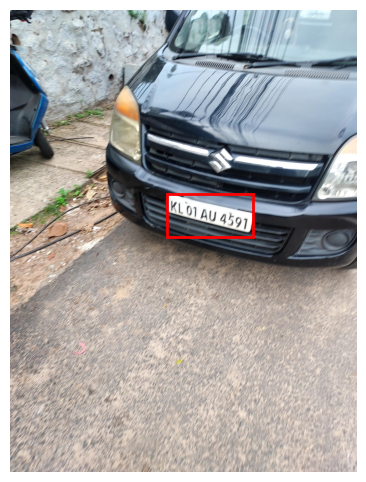

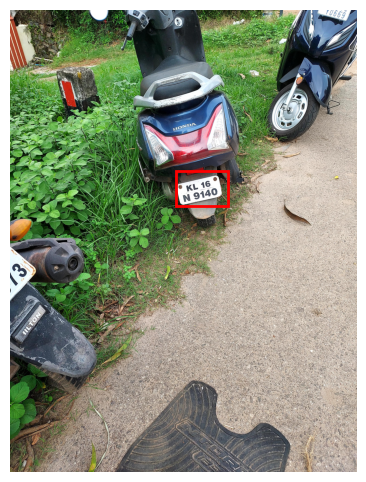

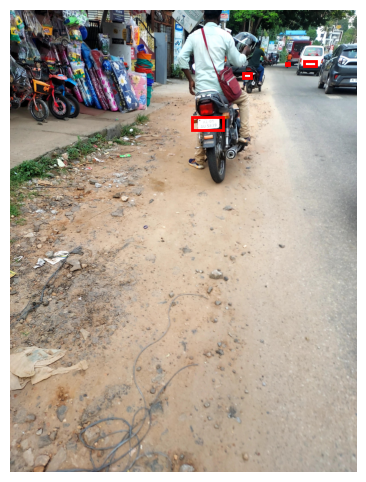

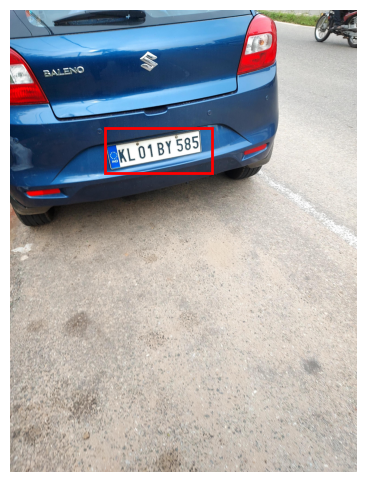

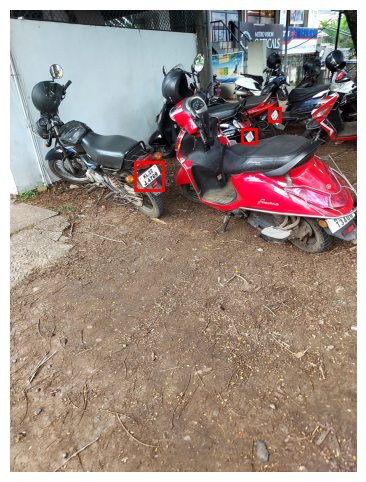

In [ ]:
# Visualize labels on a few labeled images
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from pathlib import Path

def draw_yolo_boxes(img_bgr, label_path):
    h, w = img_bgr.shape[:2]
    with open(label_path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]
    fig,ax = plt.subplots(1, figsize=(8,6))
    ax.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    for ln in lines:
        parts = ln.split()
        if len(parts) != 5:
            continue
        cls, cx, cy, bw, bh = parts
        cx, cy, bw, bh = map(float, (cx, cy, bw, bh))
        x = (cx - bw/2) * w
        y = (cy - bh/2) * h
        box_w = bw * w
        box_h = bh * h
        rect = patches.Rectangle((x,y), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.axis('off')
    plt.show()

# pick 5 labeled images randomly and show boxes
labeled_images = [str(p) for p in Path("training_dataset/images").glob("*") if p.is_file() and (Path("training_dataset/yolo_labels")/ (p.stem + ".txt")).exists()]
import random
for p in random.sample(labeled_images, min(5, len(labeled_images))):
    img = read_image_any(p)
    if img is not None:
        draw_yolo_boxes(img, Path("training_dataset/yolo_labels") / f"{Path(p).stem}.txt")


In [ ]:
import csv
from statistics import mean

# reduce blur_results to dict for quicker lookup
blur_map = {Path(p).name: var for p,b,var in blur_results}

report_path = Path("training_dataset") / "preprocess_report.csv"
with open(report_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_name","has_label","blur_var"])
    for p in sorted(image_files):
        name = Path(p).name
        has_label = "yes" if Path("training_dataset/yolo_labels", Path(p).stem + ".txt").exists() else "no"
        writer.writerow([name, has_label, blur_map.get(name, "")])

print("Report saved:", report_path)


Report saved: training_dataset/preprocess_report.csv


# **Annotation with robo flow**

In [ ]:
!pip install roboflow

  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/84/e8/0bc5996818c4566e3156102a945873f5999feec846a75d3bf19ef7e82ac2/roboflow-1.2.11-py3-none-any.whl.metadata
  Using cached roboflow-1.2.11-py3-none-any.whl.metadata (9.7 kB)
  Obtaining dependency information for idna==3.7 from https://files.pythonhosted.org/packages/e5/3e/741d8c82801c347547f8a2a06aa57dbb1992be9e948df2ea0eda2c8b79e8/idna-3.7-py3-none-any.whl.metadata
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Obtaining dependency information for requests-toolbelt from https://files.pythonhosted.org/packages/3f/51/d4db610ef29373b879047326cbf6fa98b6c1969d6f6dc423279de2b1be2c/requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached roboflow-1.2.11-py3-none-any.whl (89 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Attempti


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from roboflow import Roboflow
import os

rf = Roboflow(api_key="0VEDNNV0bZrEoHte5Kbr")

workspace_id = "number-plate-detection-of-vehicles"
project_id = "number-plate-detection-of-vehicl-q0v3s"

project = rf.workspace(workspace_id).project(project_id)

folder = "training_dataset/unlabeled_images"

for file in os.listdir(folder):
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        file_path = os.path.join(folder, file)
        print("Uploading:", file)
        project.upload(file_path)


In [ ]:
uploaded_files = [
    "20230327_170242.jpg",
    "20230327_170249.jpg",
    "20230327_170259.jpg",
    "20230418_125454.jpg",
    "20230425_163417.jpg",
    "20230515_095931.jpg",
    "20230515_125709.jpg",
    "20230515_131318.jpg",
    "20230515_133831.jpg",
    "20230516_131859.jpg",
    "20230516_154005.jpg",
    "20230516_154015.jpg",
    "20230516_154022.jpg",
    "20230516_154031.jpg",
    "20230516_154042.jpg",
    "20230516_154105.jpg",
    "20230516_154108.jpg",
    "20230516_154136.jpg",
    "20230516_154152.jpg",
    "20230516_154157.jpg",
    "20230516_154213.jpg",
    "20230516_154216.jpg",
    "20230516_154219.jpg",
    "20230516_154223.jpg",
    "20230516_154327.jpg",
    "20230516_154343.jpg",
    "20230518_065959.jpg",
    "20230518_091837.jpg",
    "20230518_091847.jpg",
    "20230518_091853.jpg",
    "20230518_091911.jpg",
    "20230518_091914.jpg",
    "20230518_091917.jpg",
    "20230518_091928.jpg",
    "20230518_091935.jpg",
    "20230518_091944.jpg",
    "20230518_091945.jpg",
    "20230518_091953(0).jpg",
    "20230518_091953.jpg",
    "20230518_091957.jpg",
    "20230518_092010.jpg",
    "20230518_092013.jpg",
    "20230518_092014.jpg",
    "20230518_092018.jpg",
    "20230518_092021.jpg",
    "20230518_092025.jpg",
    "20230518_092045.jpg",
    "20230518_092053.jpg",
    "20230518_092103.jpg",
    "20230518_092110.jpg",
    "20230518_092143.jpg",
    "20230518_092144.jpg",
    "20230518_092149.jpg",
    "20230518_092152.jpg",
    "20230518_092154.jpg",
    "20230518_092313.jpg",
    "20230518_092338.jpg",
    "20230518_092344.jpg",
    "20230518_092348.jpg",
    "20230518_092350.jpg",
    "20230518_092358.jpg",
    "20230518_092400.jpg",
    "20230518_092401.jpg",
    "20230518_092406.jpg",
    "20230518_092407.jpg",
    "20230518_092409.jpg",
    "20230527_054402.jpg",
    "20230614_150858ll.jpg",
    "20230614_151247ll.jpg",
    "20230619_182717ll.jpg",
    "20230619_182729ll.jpg",
    "20230619_182731ll.jpg",
    "20230620_155832ll.jpg",
    "20230620_160059ll.jpg",
    "20230620_160851ll.jpg",
    "20230620_161305.jpg",
    "20230620_161309.jpg",
    "20230620_161311.jpg",
    "20230620_161316.jpg",
    "20230620_161321.jpg",
    "20230620_161323.jpg",
    "20230620_161329.jpg",
    "20230620_161335.jpg",
    "20230620_161338.jpg",
    "20230620_161339.jpg",
    "20230620_161340.jpg",
    "20230620_161342.jpg",
    "20230620_161346.jpg",
    "20230620_161350.jpg",
    "20230620_161351.jpg",

    # Newly added images
    "20230620_161355.jpg",
    "20230620_161402.jpg",
    "20230622_061634.jpg",
    "20230622_061642.jpg",
    "20230622_152224.jpg",
    "20230622_152225.jpg",
    "20230624_184848.jpg",
    "20230624_184914.jpg",
    "20230624_184921.jpg",
    "20230626_091534.jpg",
    "20230626_091536.jpg",
    "20230626_091537.jpg",
    "20230626_091541.jpg",
    "20230626_091543.jpg",
    "20230626_091545.jpg",
    "20230626_091547.jpg",
    "20230626_091550.jpg",
    "20230626_091552.jpg",
    "20230626_091553.jpg",
    "20230626_091555.jpg",
    "20230626_091557.jpg",
    "20230626_091559.jpg",
    "20230626_091621.jpg",
    "20230626_091623.jpg",
    "20230626_091625.jpg",

    # NEW NEW IMAGES YOU ADDED NOW:
    "20230626_091628.jpg",
    "20230626_091634.jpg",
    "20230626_091636.jpg",
    "20230626_091638.jpg",
    "20230626_091639.jpg",
    "20230626_091641.jpg",
    "20230626_091642.jpg",
    "20230626_091644.jpg",
    "20230626_091650.jpg",
    "20230626_091651.jpg",
    "20230626_091652.jpg",
    "20230626_091654.jpg",
    "20230626_091657.jpg",
    "20230626_091702.jpg",
    "20230626_091708.jpg",
    "20230626_091711.jpg",
    "20230626_091713.jpg",
    "20230702_133115.jpg",
    "20230707_133949.jpg",
    "20230707_135450.jpg",
    "20230707_152433.jpg",
    "20230707_152443.jpg",
    "20230707_161708.jpg",
    "20230707_162111.jpg",
    "20230707_162117.jpg"
]


In [ ]:
from roboflow import Roboflow
import os
uploaded_set = set(uploaded_files)

LOCAL_FOLDER = "training_dataset/unlabeled_images"

local_files = [
    f for f in os.listdir(LOCAL_FOLDER)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

missing_files = [f for f in local_files if f not in uploaded_set]

print("Total local images:", len(local_files))
print("Already uploaded:", len(uploaded_set))
print("Missing images:", len(missing_files))


Total local images: 295
Already uploaded: 115
Missing images: 180


In [ ]:

API_KEY = "0VEDNNV0bZrEoHte5Kbr"
WORKSPACE = "number-plate-detection-of-vehicles"
PROJECT = "number-plate-detection-of-vehicl-q0v3s"
BATCH_ID = "Pip Package Upload"

LOCAL_FOLDER = "training_dataset/unlabeled_images"

# Initialize RF
rf = Roboflow(api_key=API_KEY)
project = rf.workspace(WORKSPACE).project(PROJECT)

# Upload only missing files (assuming you already created missing_files list)
for f in missing_files:
    path = os.path.join(LOCAL_FOLDER, f)
    print("Uploading:", f)
    project.upload(path, batch_name=BATCH_ID)

print("✔ Upload finished — All missing images uploaded to batch", BATCH_ID)

loading Roboflow workspace...
loading Roboflow project...
Uploading: 20230626_091628.jpg
Uploading: 20230626_091634.jpg
Uploading: 20230626_091636.jpg
Uploading: 20230626_091638.jpg
Uploading: 20230626_091639.jpg
Uploading: 20230626_091641.jpg
Uploading: 20230626_091642.jpg
Uploading: 20230626_091644.jpg
Uploading: 20230626_091650.jpg
Uploading: 20230626_091651.jpg
Uploading: 20230626_091652.jpg
Uploading: 20230626_091654.jpg
Uploading: 20230626_091657.jpg
Uploading: 20230626_091702.jpg
Uploading: 20230626_091708.jpg
Uploading: 20230626_091711.jpg
Uploading: 20230626_091713.jpg
Uploading: 20230702_133115.jpg
Uploading: 20230707_133949.jpg
Uploading: 20230707_135450.jpg
Uploading: 20230707_152433.jpg
Uploading: 20230707_152443.jpg
Uploading: 20230707_161708.jpg
Uploading: 20230707_162111.jpg
Uploading: 20230707_162117.jpg


ImageUploadError: HTTPSConnectionPool(host='api.roboflow.com', port=443): Max retries exceeded with url: /dataset/number-plate-detection-of-vehicl-q0v3s/upload?api_key=0VEDNNV0bZrEoHte5Kbr&batch=Pip+Package+Upload (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2406)')))

# YOLO Model Training

## Dataset Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil

# ---------------- CONFIG ----------------
CSV_PATH = "/content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles/Data.csv"
DATASET_ROOT = Path("/content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles")
OUT_ROOT = DATASET_ROOT / "training_dataset"

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
SEED = 42

# ---------------- LOAD CSV ----------------
df = pd.read_csv(CSV_PATH)

# keep only labeled samples
df = df[df["has_label"] == True].copy()

# ---------------- SPLIT ----------------
train_df, temp_df = train_test_split(
    df, test_size=(1 - TRAIN_RATIO), random_state=SEED, shuffle=True
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    random_state=SEED,
    shuffle=True
)

splits = {
    "train": train_df,
    "val": val_df,
    "test": test_df
}

# ---------------- CREATE FOLDERS ----------------
for split in splits:
    (OUT_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (OUT_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

# ---------------- COPY FILES ----------------
def safe_copy(src, dst):
    if src.exists():
        shutil.copy2(src, dst)
    else:
        print(f"⚠️ Missing: {src}")

for split, split_df in splits.items():
    for _, row in split_df.iterrows():
        img_src = DATASET_ROOT / row["image_path"]
        lbl_src = DATASET_ROOT / row["label_path"]

        img_dst = OUT_ROOT / "images" / split / img_src.name
        lbl_dst = OUT_ROOT / "labels" / split / lbl_src.name

        safe_copy(img_src, img_dst)
        safe_copy(lbl_src, lbl_dst)

# ---------------- SUMMARY ----------------
print("✅ Dataset prepared successfully\n")
for split, df_ in splits.items():
    print(f"{split.upper():5} images: {len(df_)}")


✅ Dataset prepared successfully

TRAIN images: 92
VAL   images: 11
TEST  images: 12


## YAML File Creating

In [ ]:
from pathlib import Path

# Path where you want to save data.yaml
yaml_path = Path("/content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles/data.yaml")

yaml_content = """
path: /content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles/training_dataset

train: images/train
val: images/val
test: images/test

names:
  0: number_plate
"""

yaml_path.write_text(yaml_content.strip())

print(f"data.yaml created at: {yaml_path}")


data.yaml created at: /content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles/data.yaml


## Train yolo12n

In [ ]:
from ultralytics import YOLO

# Load model (small model first)
model = YOLO("/content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles/Model/yolo12m.pt")   # or your base.pt


# Train the model with your final parameter set
model.train(
    data="data.yaml",
    epochs=100,
    imgsz=640,

    degrees=10.0,
    translate=0.1,
    scale=0.5,
    shear=2.0,
    perspective=0.0005,

    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,

    fliplr=0.5,
    flipud=0.0,

    mosaic=1.0,
    mixup=0.2,

    erasing=0.4,

    # Overwrite the existing run instead of creating a new one
    project="runs",
    name="exp",  # Use a fixed experiment name
    exist_ok=True  # Overwrite the previous run
)




Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=/content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles/Model/yolo12m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79a358106240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Model prediction

In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs/exp/weights/best.pt")   # path to your weights file
# Path to the image you want to run inference on
image_path = "/content/drive/MyDrive/V2_Number-Plate-Detection-of-Vehicles/DataSet/images/20230614_150920ll.jpg"
# Run prediction on one image
results = model.predict(
    source=image_path,   # image or video path
    imgsz=640,           # optional
    conf=0.5            # confidence threshold
)

# Show output
for r in results:
    r.show()            # display result window

Output hidden; open in https://colab.research.google.com to view.

### OCR

# **Colab Streamlit Integration**

##Streamlit/Layout.py

In [ ]:
%%writefile Streamlit/Layout.py
import streamlit as st

# Page configuration
st.set_page_config(page_title="Streamlit Demo", layout="wide")
st.markdown("""
<style>

/* Sidebar header container */
div[data-testid="stLogoSpacer"] {
    height: 40px;                 /* smaller height */
    display: flex;
    align-items: center;
    padding-left: 12px;
    position: relative;
}

/* Logo + text */
div[data-testid="stLogoSpacer"]::before {
    content: "Sakthi";
    display: flex;
    align-items: center;
    gap: 10px;

    font-size: 16px;              /* smaller text */
    font-weight: 600;
    color: #ffffff;
    font-family: system-ui, -apple-system, BlinkMacSystemFont;

    padding-left: 44px;
    height: 32px;
    line-height: 32px;
}

/* Logo box */
div[data-testid="stLogoSpacer"]::after {
    content: "S";
    position: absolute;
    left: 0px;

    width: 32px;                  /* smaller logo */
    height: 32px;
    background-color: #e6e6e6;
    border-radius: 8px;

    display: flex;
    align-items: center;
    justify-content: center;

    font-size: 16px;
    font-weight: 600;
    color: #7a7a7a;
}


</style>
""", unsafe_allow_html=True)
st.divider()

# Sidebar navigation

pg = st.navigation(
    pages=[
        st.Page("Home.py", title="Home", icon="🏠"),
        st.Page("ImageDetection.py", title="Image Detection", icon="📈"),
        st.Page("LiveCameraDetection.py", title="Live Camera Detection", icon="⚙️"),
        st.Page("Results.py", title="Results", icon="📈"),
    ]
)

# Run the selected page
pg.run()




Overwriting Streamlit/Layout.py


## Streamlit/Home.py

In [ ]:
%%writefile Streamlit/Home.py
import streamlit as st

st.title("🏠 Welcome to Home")
col1, col2 = st.columns(2)

with col1:
    st.metric("Total Users", 2500, "+15%")
with col2:
    st.metric("Active Sessions", 342, "+8%")

st.write("This is your dashboard overview.")

Overwriting Streamlit/Home.py


## Streamlit/ImageDetection.py

In [ ]:
%%writefile Streamlit/ImageDetection.py
import streamlit as st
from ultralytics import YOLO
from PIL import Image, ImageOps
import numpy as np
import cv2
import easyocr
import re

# ---------------- PAGE CONFIG ----------------
st.set_page_config(page_title="Number Plate Detection", layout="wide")
st.title("🖼 Image-based Number Plate Detection with OCR")

# ---------------- LOAD MODEL ----------------
@st.cache_resource
def load_model():
    return YOLO("runs/exp/weights/best.pt")   # ✅ YOUR MODEL PATH

@st.cache_resource
def load_ocr():
    return easyocr.Reader(['en'], gpu=False)

model = load_model()
ocr_reader = load_ocr()

# ---------------- OCR PREPROCESSING ----------------
def preprocess_for_ocr(plate_rgb):
    gray = cv2.cvtColor(plate_rgb, cv2.COLOR_RGB2GRAY)

    # Improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Noise reduction while keeping edges
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,
        2
    )

    # Resize for better OCR
    thresh = cv2.resize(thresh, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    return thresh

# ---------------- UI ----------------
uploaded_file = st.file_uploader(
    "Upload a vehicle image",
    type=["jpg", "jpeg", "png"]
)

confidence = st.slider(
    "Confidence Threshold",
    min_value=0.10,
    max_value=0.90,
    value=0.40,
    step=0.05
)

st.markdown(f"**Selected Threshold:** `{confidence:.2f}`")

# ---------------- IMAGE PREVIEW ----------------
if uploaded_file:
    image = Image.open(uploaded_file)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")

    if st.button("Run Detection"):
        with st.spinner("Detecting number plates and running OCR..."):

            img_rgb = np.array(image)
            img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

            results = model.predict(
                source=img_bgr,
                conf=confidence,
                imgsz=640,
                verbose=False
            )

            for box in results[0].boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf_score = float(box.conf[0])

                # ---------------- CROP PLATE ----------------
                plate_crop = img_rgb[y1:y2, x1:x2]
                ocr_text = ""

                if plate_crop.size != 0:
                    plate_preprocessed = preprocess_for_ocr(plate_crop)

                    ocr_result = ocr_reader.readtext(
                        plate_preprocessed,
                        allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789",
                        detail=0,
                        paragraph=False
                    )

                    if ocr_result:
                        ocr_text = ocr_result[0]
                        ocr_text = re.sub(r'[^A-Z0-9]', '', ocr_text)

                # ---------------- DRAW BOX ----------------
                cv2.rectangle(
                    img_bgr,
                    (x1, y1),
                    (x2, y2),
                    (0, 255, 0),
                    3
                )

                label = f"{ocr_text} ({conf_score:.2f})" if ocr_text else f"({conf_score:.2f})"

                cv2.putText(
                    img_bgr,
                    label,
                    (x1, max(y1 - 10, 25)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (0, 255, 0),
                    2
                )

            final_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            st.subheader("Detection Result")
            st.image(final_img, use_container_width=True)

# ---------------- FOOTER ----------------
st.divider()
st.markdown(
    "<p style='text-align:center;color:gray;'>Number Plate Detection • YOLO + OCR</p>",
    unsafe_allow_html=True
)


Overwriting Streamlit/ImageDetection.py


## Streamlit/Results.py

In [ ]:
%%writefile Streamlit/Results.py
import streamlit as st

st.title("⚙️ Settings")
st.sidebar.write("---")

threshold = st.slider("Sensitivity Threshold", 0.0, 1.0, 0.5)
auto_refresh = st.checkbox("Auto Refresh", value=True)

st.write(f"✓ Settings saved - Threshold: {threshold}")


Writing Streamlit/Results.py


## Streamlit/LiveCameraDetection.py

In [ ]:
%%writefile Streamlit/LiveCameraDetection.py
import streamlit as st
from ultralytics import YOLO
import cv2
import numpy as np
import tempfile
import easyocr
import os

# ---------------- PAGE CONFIG ----------------
st.set_page_config(page_title="Video Detection", layout="wide")
st.title("🎞 Video-based Number Plate Detection")

# ---------------- LOAD MODEL ----------------
@st.cache_resource
def load_model():
    return YOLO("runs/exp/weights/best.pt")  # ✅ YOUR PATH

@st.cache_resource
def load_ocr():
    return easyocr.Reader(['en'], gpu=False)

model = load_model()
ocr_reader = load_ocr()

# ---------------- UI ----------------
confidence = st.slider(
    "Confidence Threshold",
    min_value=0.10,
    max_value=0.90,
    value=0.40,
    step=0.05
)

st.markdown(f"**Selected Threshold:** `{confidence:.2f}`")

uploaded_video = st.file_uploader(
    "Upload a video file",
    type=["mp4", "avi", "mov"]
)

# ---------------- VIDEO PROCESSING ----------------
if uploaded_video:
    tfile = tempfile.NamedTemporaryFile(delete=False)
    tfile.write(uploaded_video.read())

    cap = cv2.VideoCapture(tfile.name)
    video_placeholder = st.empty()

    if st.button("▶ Run Detection on Video"):
        with st.spinner("Processing video..."):

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                results = model.predict(
                    source=frame,
                    conf=confidence,
                    imgsz=640,
                    verbose=False
                )

                for box in results[0].boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf_score = float(box.conf[0])

                    # ---- Crop plate for OCR ----
                    plate_crop = frame[y1:y2, x1:x2]
                    ocr_text = ""

                    if plate_crop.size != 0:
                        ocr = ocr_reader.readtext(plate_crop)
                        if ocr:
                            ocr_text = ocr[0][1]

                    # ---- Draw thick bounding box ----
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

                    label = (
                        f"{ocr_text} ({conf_score:.2f})"
                        if ocr_text else f"({conf_score:.2f})"
                    )

                    cv2.putText(
                        frame,
                        label,
                        (x1, max(y1 - 10, 25)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        (0, 255, 0),
                        2
                    )

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video_placeholder.image(frame_rgb, use_container_width=True)

            cap.release()
            os.remove(tfile.name)

# ---------------- FOOTER ----------------
st.divider()
st.markdown(
    "<p style='text-align:center;color:gray;'>Video Detection • YOLO + OCR</p>",
    unsafe_allow_html=True
)


Overwriting Streamlit/LiveCameraDetection.py


# RUN Streamlit

In [ ]:
from pyngrok import ngrok
ngrok.kill()
ngrok.set_auth_token("37RE1Q1z34j4c5ev693dtZ5RRSG_4HEczch23yqiPY2kfqRsP")
ngrok.connect(8501)

<NgrokTunnel: "https://6adeb718cdd4.ngrok-free.app" -> "http://localhost:8501">

In [ ]:
!pkill -f streamlit || true

!streamlit run Streamlit/Layout.py --server.port 8501 --server.address 0.0.0.0 &

^C



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

Using CPU. Note: This module is much faster with a GPU.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
2025-12-28 14:39:20.188 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
  Stopping...


#NEW STreamlit

# **Colab New Streamlit Integration**

##Streamlit/Layout.py

In [29]:
%%writefile NewStreamlit/Layout.py
import streamlit as st

# Page configuration
st.set_page_config(page_title="Streamlit Demo", layout="wide")
st.markdown("""
<style>

/* Sidebar header container */
div[data-testid="stLogoSpacer"] {
    height: 40px;                 /* smaller height */
    display: flex;
    align-items: center;
    padding-left: 12px;
    position: relative;
}

/* Logo + text */
div[data-testid="stLogoSpacer"]::before {
    content: "Sakthi";
    display: flex;
    align-items: center;
    gap: 10px;

    font-size: 16px;              /* smaller text */
    font-weight: 600;
    color: #ffffff;
    font-family: system-ui, -apple-system, BlinkMacSystemFont;

    padding-left: 44px;
    height: 32px;
    line-height: 32px;
}

/* Logo box */
div[data-testid="stLogoSpacer"]::after {
    content: "S";
    position: absolute;
    left: 0px;

    width: 32px;                  /* smaller logo */
    height: 32px;
    background-color: #e6e6e6;
    border-radius: 8px;

    display: flex;
    align-items: center;
    justify-content: center;

    font-size: 16px;
    font-weight: 600;
    color: #7a7a7a;
}


</style>
""", unsafe_allow_html=True)
st.divider()

# Sidebar navigation

pg = st.navigation(
    pages=[
        st.Page("Dashboard.py", title="Dashboard", icon="📈"),
        st.Page("ImageDetection.py", title="Image Detection", icon="🖼️"),
        st.Page("LiveCameraDetection.py", title="Live Camera Detection", icon="📷"),
        st.Page("Results.py", title="Detection Reports", icon="📊"),
    ]
)

# Run the selected page
pg.run()




Overwriting NewStreamlit/Layout.py


##Streamlit/model_loader.py

In [13]:
%%writefile NewStreamlit/model_loader.py
from ultralytics import YOLO

def load_model():
    return YOLO("runs/exp/weights/best.pt")


Writing NewStreamlit/model_loader.py


## Streamlit/Dashboard.py

In [17]:
%%writefile NewStreamlit/Dashboard.py
import streamlit as st
import pandas as pd
import os
import matplotlib.pyplot as plt

# ---------------- PAGE CONFIG ----------------
st.set_page_config(page_title="Performance Dashboard", layout="wide")
st.title("📈 Performance Dashboard")

st.markdown(
    "This dashboard provides performance insights, confidence analysis, "
    "and detection trends for the Number Plate Detection system."
)

# ---------------- PATH ----------------
CSV_PATH = "data/detection_log.csv"

# ---------------- LOAD DATA ----------------
if not os.path.exists(CSV_PATH):
    st.warning("No detection data available. Run Image Detection first.")
    st.stop()

df = pd.read_csv(CSV_PATH)

if df.empty:
    st.info("Detection log is empty.")
    st.stop()

# ---------------- METRICS ----------------
st.subheader("🔢 Key Performance Metrics")

col1, col2, col3, col4 = st.columns(4)

with col1:
    st.metric("Total Detections", len(df))

with col2:
    st.metric(
        "Average Confidence",
        f"{df['threshold'].mean():.2f}"
    )

with col3:
    st.metric(
        "Highest Confidence",
        f"{df['threshold'].max():.2f}"
    )

with col4:
    st.metric(
        "Unique Plates",
        df["ocr_text"].nunique()
    )

# ---------------- CONFIDENCE DISTRIBUTION ----------------
st.divider()
st.subheader("📊 Confidence Threshold Distribution")

fig, ax = plt.subplots()
ax.hist(df["threshold"], bins=10)
ax.set_xlabel("Confidence Threshold")
ax.set_ylabel("Detection Count")
ax.set_title("Distribution of Confidence Thresholds")

st.pyplot(fig)

# ---------------- DETECTION OVER TIME ----------------
st.divider()
st.subheader("🕒 Detection Trend Over Time")

# Convert datetime column
df["entry_datetime"] = pd.to_datetime(df["entry_datetime"])

# Group by date
daily_counts = df.groupby(df["entry_datetime"].dt.date).size()

fig2, ax2 = plt.subplots()
ax2.plot(daily_counts.index, daily_counts.values, marker="o")
ax2.set_xlabel("Date")
ax2.set_ylabel("Number of Detections")
ax2.set_title("Detections per Day")
ax2.grid(True)

st.pyplot(fig2)

# ---------------- OCR FREQUENCY ----------------
st.divider()
st.subheader("🔤 Most Detected Plate Numbers")

ocr_counts = (
    df["ocr_text"]
    .value_counts()
    .head(10)
)

st.bar_chart(ocr_counts)

# ---------------- TABLE VIEW ----------------
st.divider()
st.subheader("📋 Raw Detection Data (Preview)")

st.dataframe(
    df.sort_values("entry_datetime", ascending=False),
    use_container_width=True
)

# ---------------- FOOTER ----------------
st.divider()
st.markdown(
    "<p style='text-align:center;color:gray;'>Performance Dashboard • Metrics & Trends</p>",
    unsafe_allow_html=True
)


Overwriting NewStreamlit/Dashboard.py


## Streamlit/ImageDetection.py

In [11]:
%%writefile NewStreamlit/ImageDetection.py
import streamlit as st
from ultralytics import YOLO
from PIL import Image, ImageOps
import numpy as np
import cv2
import easyocr
import re
import pandas as pd
import os
from datetime import datetime

# ---------------- PAGE CONFIG ----------------
st.set_page_config(page_title="Image Detection", layout="wide")
st.title("🖼 Image Upload – Number Plate Detection")

# ---------------- LOAD MODEL ----------------
@st.cache_resource
def load_model():
    return YOLO("runs/exp/weights/best.pt")   # ✅ YOUR MODEL PATH

@st.cache_resource
def load_ocr():
    return easyocr.Reader(['en'], gpu=False)

model = load_model()
ocr_reader = load_ocr()

# ---------------- DIRECTORIES ----------------
BASE_DIR = "data"
ORIGINAL_DIR = f"{BASE_DIR}/originals"
PREDICTED_DIR = f"{BASE_DIR}/predictions"
CSV_PATH = f"{BASE_DIR}/detection_log.csv"

os.makedirs(ORIGINAL_DIR, exist_ok=True)
os.makedirs(PREDICTED_DIR, exist_ok=True)
os.makedirs(BASE_DIR, exist_ok=True)

# ---------------- INIT CSV ----------------
if not os.path.exists(CSV_PATH):
    df_init = pd.DataFrame(columns=[
        "entry_datetime",
        "threshold",
        "ocr_text",
        "original_image_path",
        "predicted_image_path"
    ])
    df_init.to_csv(CSV_PATH, index=False)

# ---------------- OCR PREPROCESS ----------------
def preprocess_for_ocr(plate_rgb):
    gray = cv2.cvtColor(plate_rgb, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    thresh = cv2.resize(thresh, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    return thresh

# ---------------- UI ----------------
uploaded_file = st.file_uploader(
    "Upload a vehicle image",
    type=["jpg", "jpeg", "png"]
)

confidence = st.slider(
    "Confidence Threshold",
    0.10, 0.90, 0.40, 0.05
)

st.markdown(f"**Selected Threshold:** `{confidence:.2f}`")

# ---------------- IMAGE PIPELINE ----------------
if uploaded_file:
    image = Image.open(uploaded_file)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")

    st.subheader("Original Image Preview")
    st.image(image, use_container_width=True)

    if st.button("Run Detection"):
        with st.spinner("Running detection and OCR..."):

            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            original_path = f"{ORIGINAL_DIR}/img_{timestamp}.jpg"
            predicted_path = f"{PREDICTED_DIR}/pred_{timestamp}.jpg"

            image.save(original_path)

            img_rgb = np.array(image)
            img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

            results = model.predict(
                source=img_bgr,
                conf=confidence,
                imgsz=640,
                verbose=False
            )

            ocr_values = []

            for box in results[0].boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf_score = float(box.conf[0])

                plate_crop = img_rgb[y1:y2, x1:x2]
                ocr_text = ""

                if plate_crop.size != 0:
                    plate_proc = preprocess_for_ocr(plate_crop)
                    ocr_result = ocr_reader.readtext(
                        plate_proc,
                        allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789",
                        detail=0
                    )
                    if ocr_result:
                        ocr_text = re.sub(r'[^A-Z0-9]', '', ocr_result[0])
                        ocr_values.append(ocr_text)

                cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 3)

                label = f"{ocr_text} ({conf_score:.2f})" if ocr_text else f"({conf_score:.2f})"
                cv2.putText(
                    img_bgr,
                    label,
                    (x1, max(y1 - 10, 25)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (0, 255, 0),
                    2
                )

            final_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            Image.fromarray(final_img).save(predicted_path)

            # ---------------- SAVE LOG ----------------
            log_row = {
                "entry_datetime": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "threshold": confidence,
                "ocr_text": ", ".join(ocr_values),
                "original_image_path": original_path,
                "predicted_image_path": predicted_path
            }

            df = pd.read_csv(CSV_PATH)
            df = pd.concat([df, pd.DataFrame([log_row])], ignore_index=True)
            df.to_csv(CSV_PATH, index=False)

            st.subheader("Detection Result")
            st.image(final_img, use_container_width=True)

            st.success("✅ Detection logged successfully")


# ---------------- FOOTER ----------------
st.divider()
st.markdown(
    "<p style='text-align:center;color:gray;'>Number Plate Detection • YOLO + OCR</p>",
    unsafe_allow_html=True
)


Writing NewStreamlit/ImageDetection.py


## Streamlit/LiveCameraDetection.py

In [15]:
%%writefile NewStreamlit/LiveCameraDetection.py
import streamlit as st
from streamlit_webrtc import webrtc_streamer, VideoProcessorBase, WebRtcMode
import av
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
import re

# ---------------- PAGE CONFIG ----------------
st.set_page_config(page_title="Live Camera Detection", layout="wide")
st.title("📷 Live Camera Detection")

st.markdown(
    "Real-time number plate detection using live camera feed with OCR output.",
)

# ---------------- LOAD MODEL ----------------
@st.cache_resource
def load_model():
    return YOLO("runs/exp/weights/best.pt")  # ✅ YOUR MODEL PATH

@st.cache_resource
def load_ocr():
    return easyocr.Reader(['en'], gpu=False)

model = load_model()
ocr_reader = load_ocr()

# ---------------- USER CONTROLS ----------------
confidence = st.slider(
    "Confidence Threshold",
    min_value=0.10,
    max_value=0.90,
    value=0.40,
    step=0.05
)

st.markdown(f"**Selected Threshold:** `{confidence:.2f}`")

# ---------------- VIDEO PROCESSOR ----------------
class VideoProcessor(VideoProcessorBase):
    def recv(self, frame):
        img = frame.to_ndarray(format="bgr24")

        results = model.predict(
            source=img,
            conf=confidence,
            imgsz=640,
            verbose=False
        )

        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf_score = float(box.conf[0])

            plate_crop = img[y1:y2, x1:x2]
            ocr_text = ""

            if plate_crop.size != 0:
                ocr_result = ocr_reader.readtext(
                    plate_crop,
                    allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789",
                    detail=0
                )
                if ocr_result:
                    ocr_text = re.sub(r'[^A-Z0-9]', '', ocr_result[0])

            # ---- Draw thick bounding box ----
            cv2.rectangle(
                img,
                (x1, y1),
                (x2, y2),
                (0, 255, 0),
                3
            )

            # ---- Label (OCR + confidence only) ----
            label = f"{ocr_text} ({conf_score:.2f})" if ocr_text else f"({conf_score:.2f})"

            cv2.putText(
                img,
                label,
                (x1, max(y1 - 10, 25)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 255, 0),
                2
            )

        return av.VideoFrame.from_ndarray(img, format="bgr24")

# ---------------- WEBRTC STREAM ----------------
webrtc_streamer(
    key="live-camera-detection",
    mode=WebRtcMode.SENDRECV,
    video_processor_factory=VideoProcessor,
    media_stream_constraints={"video": True, "audio": False},
)

# ---------------- FOOTER NOTE ----------------
st.divider()
st.markdown(
    "<p style='text-align:center;color:gray;'>Live Camera Detection • YOLO + OCR</p>",
    unsafe_allow_html=True
)


Writing NewStreamlit/LiveCameraDetection.py


## Streamlit/Results.py

In [16]:
%%writefile NewStreamlit/Results.py
import streamlit as st
import pandas as pd
import os
from PIL import Image

# ---------------- PAGE CONFIG ----------------
st.set_page_config(page_title="Detection Reports", layout="wide")
st.title("📊 Detection Reports & Logs")

st.markdown(
    "This page displays all detection logs, OCR results, confidence thresholds, "
    "and allows downloading the report as CSV."
)

# ---------------- PATHS ----------------
DATA_DIR = "data"
CSV_PATH = f"{DATA_DIR}/detection_log.csv"

ORIGINAL_DIR = f"{DATA_DIR}/originals"
PREDICTED_DIR = f"{DATA_DIR}/predictions"

# ---------------- CHECK CSV ----------------
if not os.path.exists(CSV_PATH):
    st.warning("No detection logs found yet. Run Image Detection first.")
    st.stop()

# ---------------- LOAD DATA ----------------
df = pd.read_csv(CSV_PATH)

if df.empty:
    st.info("Detection log is empty.")
    st.stop()

# ---------------- FILTER SECTION ----------------
st.subheader("🔍 Filter Logs")

col1, col2 = st.columns(2)

with col1:
    min_threshold = st.slider(
        "Minimum Confidence Threshold",
        0.0, 1.0, 0.0, 0.05
    )

with col2:
    search_ocr = st.text_input(
        "Search OCR Text (optional)",
        placeholder="e.g. KL41"
    )

filtered_df = df[df["threshold"] >= min_threshold]

if search_ocr:
    filtered_df = filtered_df[
        filtered_df["ocr_text"].str.contains(search_ocr, case=False, na=False)
    ]

# ---------------- TABLE VIEW ----------------
st.subheader("📋 Detection Log Table")

st.dataframe(
    filtered_df,
    use_container_width=True
)

# ---------------- IMAGE PREVIEW SECTION ----------------
st.subheader("🖼 Detection Image Preview")

for _, row in filtered_df.iterrows():
    with st.expander(
        f"{row['entry_datetime']} | OCR: {row['ocr_text']} | Threshold: {row['threshold']}"
    ):
        col_img1, col_img2 = st.columns(2)

        # Original image
        with col_img1:
            st.markdown("**Original Image**")
            if os.path.exists(row["original_image_path"]):
                st.image(
                    Image.open(row["original_image_path"]),
                    use_container_width=True
                )
            else:
                st.warning("Original image not found")

        # Predicted image
        with col_img2:
            st.markdown("**Predicted Image**")
            if os.path.exists(row["predicted_image_path"]):
                st.image(
                    Image.open(row["predicted_image_path"]),
                    use_container_width=True
                )
            else:
                st.warning("Predicted image not found")

# ---------------- DOWNLOAD SECTION ----------------
st.divider()
st.subheader("⬇ Download & Export")

st.download_button(
    label="Download Detection Log (CSV)",
    data=df.to_csv(index=False),
    file_name="number_plate_detection_log.csv",
    mime="text/csv"
)

# ---------------- SUMMARY METRICS ----------------
st.divider()
st.subheader("📈 Quick Summary")

col1, col2, col3 = st.columns(3)

with col1:
    st.metric("Total Detections", len(df))

with col2:
    st.metric(
        "Average Threshold",
        f"{df['threshold'].mean():.2f}"
    )

with col3:
    st.metric(
        "Unique Plates Detected",
        df["ocr_text"].nunique()
    )

# ---------------- FOOTER ----------------
st.divider()
st.markdown(
    "<p style='text-align:center;color:gray;'>Detection Reports • Download & Export Enabled</p>",
    unsafe_allow_html=True
)


Writing NewStreamlit/Results.py


# RUN New Streamlit

In [30]:
from pyngrok import ngrok
ngrok.kill()
ngrok.set_auth_token("37RE1Q1z34j4c5ev693dtZ5RRSG_4HEczch23yqiPY2kfqRsP")
ngrok.connect(8501)

<NgrokTunnel: "https://d981529f2f5d.ngrok-free.app" -> "http://localhost:8501">

In [ ]:
!pkill -f streamlit || true

!streamlit run NewStreamlit/Layout.py --server.port 8501 --server.address 0.0.0.0 &

^C



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

Using CPU. Note: This module is much faster with a GPU.
Progress: |██████████████████████████████████████████████████| 100.0% CompleteDownloading recognition model, please wait. This may take several minutes depending upon your network connection.
Progress: |██████████████████████████████████████████████████| 100.0% Complete2025-12-29 05:22:40.052 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-12-29 05:22:46.755 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_me